# Score Matching

This section is about learning a score function from data using a neural network.
We will not yet address the notion of sampling from the SBM, 
which is covered in the next section on [diffusion](./03-diffusion.ipynb). 

## Naive Score Matching

Constructing a loss function for score-matching is rather straight forward. The procedure was first described 
by [Aapo Hyvärinen](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf) in 2005. 
Suppose $\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n$ is a neural network with parameters $\theta$. This network 
can be trained to match a score function by minimizing the mean squared error loss function

$$
    \mathcal{L}_\theta = \mathbb{E}_{p(\mathbf{x})} 
    \bigg[\big\lVert \mathbf{s}_\theta(\mathbf{x}) - \nabla_{\mathbf{x}} \log p(\mathbf{x}) \big\rVert^2_2 \bigg]
$$

This construction is naive because it assumes we have access to the ground truth score, $\nabla_{\mathbf{x}} \log p(\mathbf{x})$. Naturally, there would be no need to train a neural network if we did. This is why Hyvärinen (2005) derived an equivalent loss 
function which abstracts away the ground truth score. His work eventually led Yang Song to build the Sliced Score Matching (SSM) loss function ([Song et al. (2019)](https://arxiv.org/abs/1905.07088)) using the Hutchinson trace estimator to speed up the Hessian trace in Hyvärinen's loss function.

Instead of the SSM loss function, we will focus on the naive score matching approach to demonstrate some of its pitfalls (which the SSM also inherited). 
As it turns out, score matching is not straightforward even when given perfect information about the ground truth score.

We will build score-matching from scratch to showcase the internals of the score models package. All that we do here is abstracted away in the package. You can find the relevant routines in the [Getting Started](./00-Overview.md) page.

In [29]:
!pip install --quiet score_models colorcet SciencePlots tqdm # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Score model with signature $\mathbf{s}_\theta: \mathbb{R}^n \rightarrow \mathbb{R}^n$

In [64]:
class SBM(nn.Module):
    def __init__(self, n, depth=2, width=100):
        super().__init__()
        self.n = n
        module_list = [nn.Linear(n, width)] # Input layer n -> width
        for i in range(depth):
            module_list.append(nn.Linear(width, width))
        self.output_layer = nn.Linear(width, n) # Output layer width -> n
        self.layers = nn.ModuleList(module_list)
    
    def forward(self, x):
        for layer in self.layers:
            x = F.silu(layer(x))
        x = self.output_layer(x) # Output layer has no activation function
        return x

### Ground-truth score function


In [65]:
distribution = egg_box(4, mode_width=0.1, box_size=1)

def logp(x):
    return distribution.log_prob(x)

def score(x):
    return vmap(grad(logp))(x)

### Training the SBM

In [66]:
def naive_score_matching_loss(x, sbm):
    return ((score(x) - sbm(x))**2).flatten(1).sum(1).mean()

In [67]:
N = int(2e3)  # Number of iterations
B = int(2**8) # Batch size
net = SBM(2)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(N)):
    x = distribution.sample((B,))
    loss = naive_score_matching_loss(x, net)
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

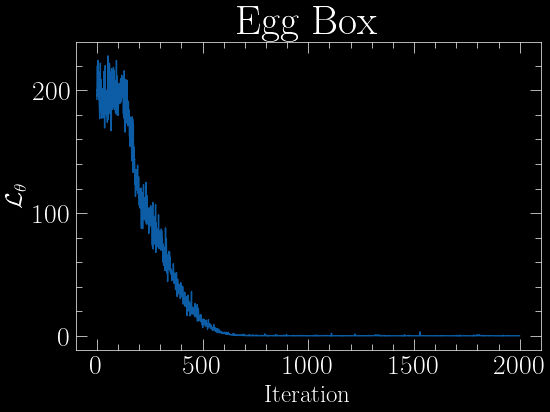

In [68]:
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title(r"Egg Box")
plt.ylabel(r"$\mathcal{L}_\theta$")
plt.xlabel("Iteration");

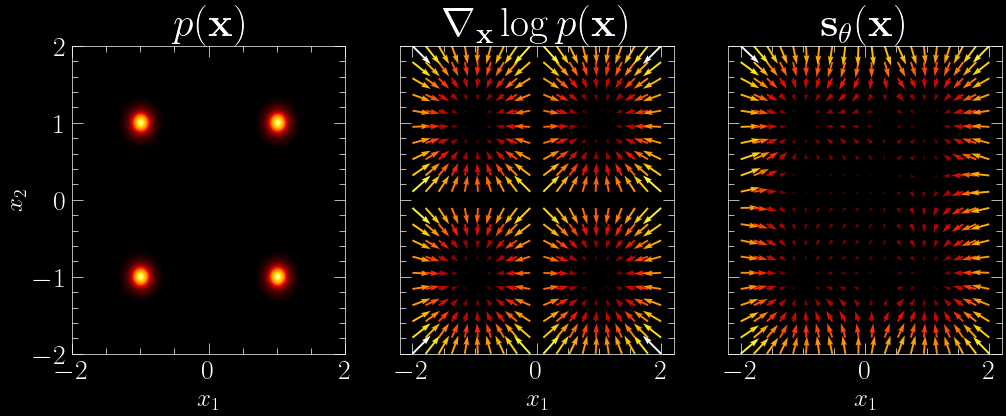

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
extent = (-2, 2, -2, 2)

ax = axs[0]
plot_density(logp, ax=ax, extent=extent)
ax.set_title(r"$ p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$")

ax = axs[1]
plot_score(score, ax=ax, extent=extent)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$")

ax = axs[2]
plot_score(net, ax=ax, extent=extent)
ax.set_title(r"$\mathbf{s}_\theta(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");

Close to each mode, the score is very well approximated. But, in between the modes, the model is a 
rather poor approximation of the ground truth score even though the loss $\mathcal{L}_\theta$ is very close to zero (see loss curve above). 

When we train the neural network, we do not uniformly sample the ambiant space $\mathbb{R}^n$. Rather, we sample from the distribution $p(\mathbf{x})$. It is almost impossible to sample a point in between the modes &mdash; which we chose to be well-separated. The loss function is blind there. 

One might suggest to change the sampling distribution to something more uniform. Although this might work for our toy example, this approach is bound to fail for high-dimensional spaces (like images). The volume of the space scales exponentially with the dimensionality of the space, $\mathcal{V} \propto C^n$. And there is this thing called the manifold hypothesis, which claims (rightly) that data typically belongs to a manifold of dimensionality far smaller than the ambiant space in which we observe it. In other words, the probability of randomly choosing a valid sample from $p(\mathbf{x})$ in $\mathbb{R}^n$ is 
vanishingly small as $n$ increases &mdash; at least for interesting $p(\mathbf{x})$. If we want to approximate the score of $p(\mathbf{x})$, we better make sure our score is good near points of high-density. 

Furthermore, there are good theoretical reasons to have $p(\mathbf{x})$ as our sampling distribution. In fact, the loss $\mathcal{L}_\theta$ is a forward Fisher divergence, which is closely related to the Kullback-Leibler divergence. We will come back to this point later.

So what do we do? Before giving the answer, let's just put to rest one worry. Yes, I have cherry-picked the example. In fact, if the modes are closer together, the naive score-matching approach works a little bit better.

In [60]:
distribution = two_moons()

In [61]:
N = int(2e3)  # Number of iterations
B = int(2**8) # Batch size
net = SBM(2)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for i in tqdm(range(N)):
    x = distribution.sample((B,))
    loss = naive_score_matching_loss(x, net)
    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

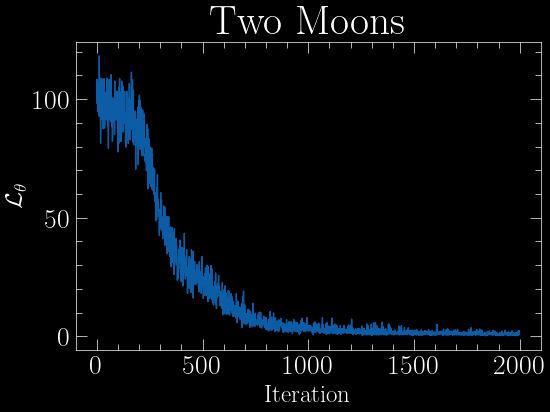

In [62]:
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title(r"Two Moons")
plt.ylabel(r"$\mathcal{L}_\theta$")
plt.xlabel("Iteration");

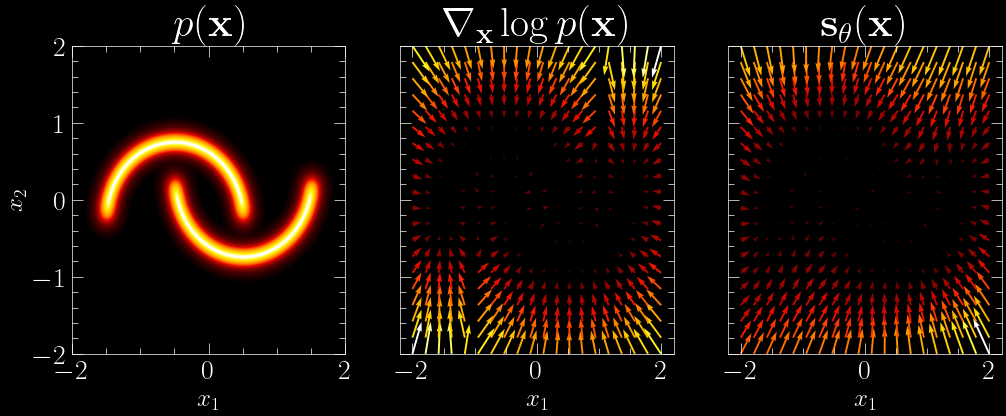

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
extent = (-2, 2, -2, 2)

ax = axs[0]
plot_density(logp, ax=ax, extent=extent)
ax.set_title(r"$ p(\mathbf{x})$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$")

ax = axs[1]
plot_score(score, ax=ax, extent=extent)
ax.set_title(r"$\nabla_{\mathbf{x}} \log p(\mathbf{x})$")
ax.set_xlabel(r"$x_1$")

ax = axs[2]
plot_score(net, ax=ax, extent=extent)
ax.set_title(r"$\mathbf{s}_\theta(\mathbf{x})$")
ax.set_xlabel(r"$x_1$");

## Denoising Score-Matching (DSM)

## Adding different levels of noise (DDPM)

## Continuous-time DSM (Diffusion)